In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import models
from keras import layers
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint

import pathlib
import cv2
import pandas



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copy("./drive/MyDrive/models/best-model.pth", "./models/best-model.pth")

'./models/best-model.pth'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
!ls

drive  final_mask  final_vlad  PM25.csv  sample_data  vlad.csv


In [10]:
!unzip -n './drive/MyDrive/models/mearth.zip'

Archive:  ./drive/MyDrive/models/mearth.zip
  inflating: final_mask/bacninh_caoduc.png  
  inflating: final_mask/bacninh_cho.png  
  inflating: final_mask/bacninh_suoihoa.png  
  inflating: final_mask/baria.png    
  inflating: final_mask/caobang_detham.png  
  inflating: final_mask/danang.png   
  inflating: final_mask/danang_thachthang.png  
  inflating: final_mask/daocathai.png  
  inflating: final_mask/haiphong.png  
  inflating: final_mask/haiphong_anhdung.png  
  inflating: final_mask/haiphong_cathai.png  
  inflating: final_mask/halong.png   
  inflating: final_mask/hanam_trangan.png  
  inflating: final_mask/hanoi_caugiay.png  
  inflating: final_mask/hanoi_conhue.png  
  inflating: final_mask/hanoi_cuanam.png  
  inflating: final_mask/hanoi_cukhoi.png  
  inflating: final_mask/hanoi_giathuy.png  
  inflating: final_mask/hanoi_lienquan.png  
  inflating: final_mask/hanoi_minhkhai.png  
  inflating: final_mask/hanoi_ngoclam.png  
  inflating: final_mask/hanoi_phumy.png  
  infla

In [27]:
# Parametres
train = pathlib.Path(r'./PM2.5.csv')
valid = pathlib.Path(r'./vlad.csv')
altitude = 2.4

In [28]:
def get_data():
    print('date?')
    dataframe1 = pandas.read_csv(train, delimiter=',', names=["ct", "airq"])
    dataframe2 = pandas.read_csv(valid, delimiter=',', names=["ct", "airq"])
    print(dataframe1)
    print(dataframe2)
    l_train = np.asarray(dataframe1)
    l_valid = np.asarray(dataframe2)
    print(l_train.shape, l_valid.shape)
    x_train, y_train = l_train[:, 0], l_train[:, 1]
    x_valid, y_valid = l_valid[:, 0], l_valid[:, 1]
    y_train = y_train.astype('float32')
    y_valid = y_valid.astype('float32')
    images_train = np.zeros(shape=(len(l_train), 512, 512, 3))
    images_valid = np.zeros(shape=(len(l_valid), 512, 512, 3))
    for i in range(len(l_train)):
        print('./final_mask/'+x_train[i]+'.png')
        im = cv2.imread('./final_mask/'+x_train[i]+'.png')
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (512, 512), interpolation = cv2.INTER_LANCZOS4)
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        images_train[i] = np.asarray(im).astype('float32')
        #images[i] = images[i]/255
    for i in range(len(l_valid)):
        im = cv2.imread('./final_vlad/'+x_valid[i]+'.png')
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (512, 512), interpolation = cv2.INTER_LANCZOS4)
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        images_valid[i] = np.asarray(im).astype('float32')
    return images_train, y_train, images_valid, y_valid

In [7]:
def build_model(com):

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation=None))

    if com == True:
      model.compile(
          optimizer='rmsprop',
          loss='mse',
          metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    model.summary()

    return model

In [37]:
def train_model(model):
  save_at = "macbeth.hdf5"
  save_best2 = ModelCheckpoint (save_at, monitor='val_mean_absolute_error', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

  x_train, y_train, x_test, y_test = get_data()


  # Run model and get metrics for each epoch
  history = model.fit(
      x_train,
      y_train,
      callbacks=[
          #EarlyStopping(monitor='val_mean_absolute_error', patience=5, restore_best_weights=True)
          save_best2
          ],
      epochs=50,
      batch_size=1,
      validation_data=(x_test, y_test)
      )

  return history

In [36]:
def loss_plot(history):
    plt.plot(history.history['loss'][3:])
    plt.plot(history.history['val_loss'][3:])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [49]:
def reformat_mask_for_pred(img):
  im = cv2.imread(img)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  #print(im)
  im = cv2.resize(im, (512, 512), interpolation = cv2.INTER_LANCZOS4)     # resize image to match model's expected sizing
  #print(im)
  im = im.reshape(1,512,512,3)
  #print(im)
  x = np.asarray(im).astype('float32')
  #print(x)
  #im = Image.open('./mask.jpg')
  #im = im.convert('L')
  x = np.zeros(shape=(1, 512, 512, 3))
  x = np.asarray(im).astype('float32')
  #print(x)
  #x = x/255
  return x

In [ ]:
from fastai.vision.all import *

In [ ]:
def build_model1(model_path):
  from tqdm import tqdm
  import pathlib
  plt = platform.system()
  print(plt)
  if plt == 'Linux': pathlib.WindowsPath = pathlib.PosixPath
  torch.cuda.empty_cache()

  #model = unet_learner(arch=xresnet34)
  model = load_learner(model_path+r'berlin3.pkl', cpu=False)
  model.load('best-model')
  return model

SyntaxError: import * only allowed at module level (<ipython-input-11-f3d0743f2f33>, line 2)

In [ ]:
from PIL import Image

def generate_pred_model1(model):
  pics = os.listdir(r'./earth/')
  for img in pics:
    torch.cuda.empty_cache()
    im = Image.open(r'./earth/'+img)
    im.thumbnail((3000, 3000), Image.Resampling.LANCZOS)
    m = model.predict(im)
    m = to_image(m[2][1].repeat(3,1,1))
    pathsave = r'./earth_pics/'+img
    m.save(pathsave, "JPEG")

In [ ]:
def get_image_tiles_NEW2(path:Path) -> L:
   files = L()
   files = get_image_files(path=path, folders='im_tiles_ds2')
   return files

def get_y_fn_NEW2(fn:Path) -> str:
  #print(str(fn).replace('im_tiles', 'gt_tiles'))
  return str(fn).replace('im_tiles', 'gt_tiles')

def get_y_NEW2(fn:Path) -> PILMask:
   fn = get_y_fn_NEW2(fn)
   msk = np.array(PILMask.create(fn))
   #print(msk)
   #msk[msk==255] = 1
   msk = msk / 255
   #print(msk)
   return PILMask.create(msk)

vowlr
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 984064)       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 5s 72ms/step - loss: 14335525.0000 - mean_absolute_error: 661.9969 - root_mean_squared_error: 3786.2283 - val_loss: 10736.3281 - val_mean_absolute_error: 97.5781 - val_root_mean_squared_error: 103.6163
Epoch 2/50
53/53 [==============================] - 4s 71ms/step - loss: 5300.7437 - mean_absolute_error: 49.3910 - root_mean_squared_error: 72.8062 - val_loss: 14138.4648 - val_mean_absolute_error: 112.8643 - val_root_mean_squared_error: 118.9053
Epoch 3/50
53/53 [==============================] - 6s 109ms/step - loss: 4275.8994 - mean_absolute_error: 41.8752 - root_mean_squared_error: 65.3904 - val_loss: 15270.4922 - val_mean_absolute_error: 117.7876 - val_root_mean_squared_error: 123.5738
Epoch 4/50
53/53 [==============================] - 1s 24ms/step - loss: 6258.0747 - mean_absolute_error: 50.0936 - root_mean_squared_error: 79.1080 - val_loss: 13905.4736 - val_mean_absolute_error: 111.3656 - val_root_mean_squared_error: 117.9215
Epoch 5/50
5

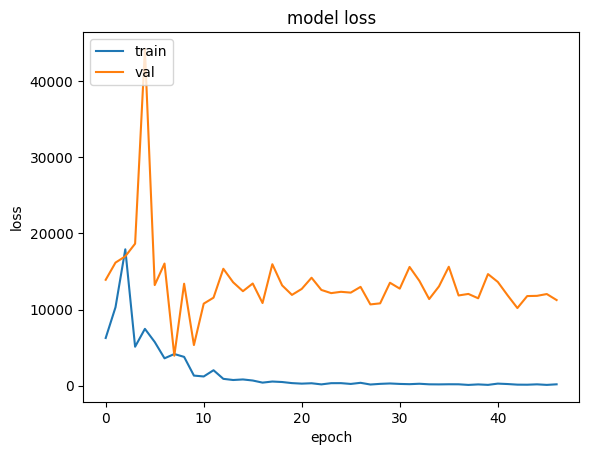

In [38]:
if __name__ == "__main__":
    print('vowlr')
    tf.keras.backend.clear_session()

    model1path = './drive/MyDrive/models/'

    #model1 = build_model1(model1path)
    #generate_pred_model1(model1)

    #model = build_model(True)
    #model.load_weights('macbeth.hdf5')
    #history = train_model(model)
    #loss_plot(history)

    mode = build_model(True)
    his = train_model(mode)
    loss_plot(his)

In [50]:
if __name__ == "__main__":
  print('vowlr')
  tf.keras.backend.clear_session()

  model = build_model(True)
  model.load_weights('macbeth.hdf5')

  x = reformat_mask_for_pred('./mask2.png')
  y = model.predict(x)
  print(-y[0])

vowlr
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 984064)       

In [ ]:
!zip -r './file.zip' './earth_pics/'

  adding: earth_pics/ (stored 0%)
  adding: earth_pics/hanoi_conhue.jpg (deflated 9%)
  adding: earth_pics/hanoi_cuanam.jpg (deflated 1%)
  adding: earth_pics/hcm_tanphu.jpg (deflated 2%)
  adding: earth_pics/hanoi_socson.jpg (deflated 8%)
  adding: earth_pics/hanoi_tulien.jpg (deflated 4%)
  adding: earth_pics/hanoi_minhkhai.jpg (deflated 0%)
  adding: earth_pics/hcm_govap.jpg (deflated 0%)
  adding: earth_pics/phuquoc_nam.jpg (deflated 9%)
  adding: earth_pics/quangninh_uongbi.jpg (deflated 2%)
  adding: earth_pics/hanoi_quangan.jpg (deflated 16%)
  adding: earth_pics/hanoi_caugiay.jpg (deflated 1%)
  adding: earth_pics/hanoi_vandien.jpg (deflated 2%)
  adding: earth_pics/hcm_q10.jpg (deflated 0%)
  adding: earth_pics/hanoi_tayho.jpg (deflated 6%)
  adding: earth_pics/hanoi_ngoclam.jpg (deflated 1%)
  adding: earth_pics/hanoi_quocoai.jpg (deflated 4%)
  adding: earth_pics/danang.jpg (deflated 0%)
  adding: earth_pics/baria.jpg (deflated 1%)
  adding: earth_pics/halong.jpg (deflated 5

In [51]:
from google.colab import files
files.download("./macbeth.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>